In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from tflearn.layers.core import fully_connected
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
%matplotlib inline

## Data acquisition

Load the data.

In [15]:
data_dir = 'data'
files = os.listdir(data_dir)
df = pd.DataFrame(columns=['record', 'distance', 'speed'])

def get_record(distance, speed):
    
    return df['record'][ (df['distance'] == distance) & (df['speed'] == speed) ].tolist()[0]


for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    # put the data into the DataFrame
    df = df.append(dict(
        { 'record'   : np.divide(data, np.max(data)), 
          'distance' : decoded_classes[0],
          'speed'    : decoded_classes[1] }), ignore_index=True)
    
DISTANCES = sorted(df.distance.unique())
SPEEDS = sorted(df.speed.unique())

### Exploration of raw data

Plot several raw signals for several speeds and distances.

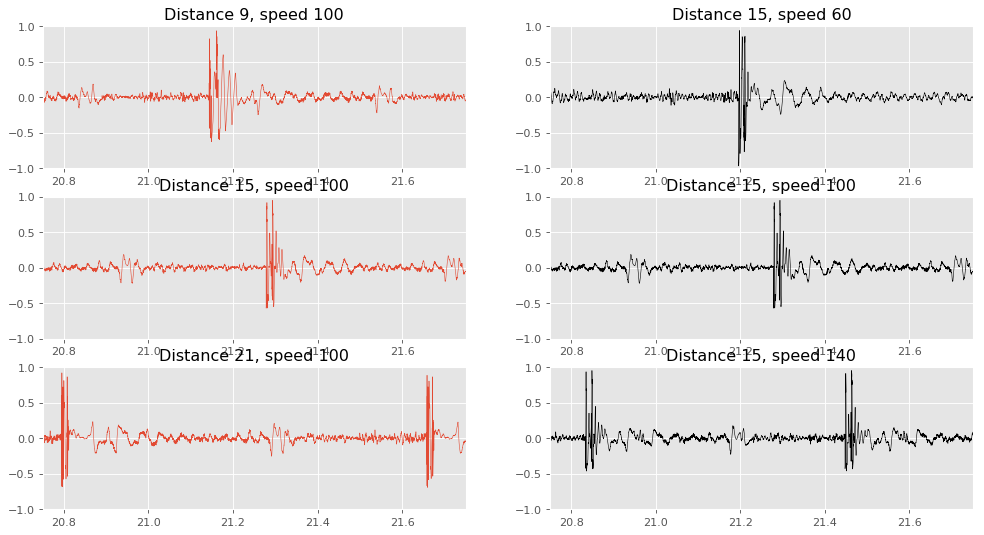

In [16]:
plt.figure(num=None, figsize=(15, 8), dpi=80)
plt.style.use('ggplot')

PLT_DISTANCE = 15
PLT_SPEED = 100

# plot for varying speed
for speed in range(60, 150, 40):
    data = get_record(PLT_DISTANCE, speed)
    plt.subplot(3, 2, int(speed / 40) * 2)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, color='k', linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (PLT_DISTANCE, speed))
    
# plot for varying distance
for distance in range(9, 22, 6):
    data = get_record(distance, PLT_SPEED)
    plt.subplot(3, 2, int(distance / 7) * 2 - 1)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (distance, PLT_SPEED))

## Finding peaks

In [17]:
EXPECTED_CONTACTS = 100
THRESHOLD = .6 #1844146018536
FRAGMENT_SIZE = 2048
SAMPLES_BETWEEN_CONTACTS = 8192

def find_peaks(x, method='last_peaks'):
    above_th = pd.Series(x) > THRESHOLD
    # find every threshold transgression
    above_th = pd.Series(above_th.index[above_th == True].tolist()).astype(int)
    diff = above_th.diff(periods=-1).abs()
    if method == 'first_peaks':
        diff = diff.shift(1).fillna(SAMPLES_BETWEEN_CONTACTS)
    peaks_indices = diff.index[diff >= SAMPLES_BETWEEN_CONTACTS].tolist()
    peaks_indices.append(len(above_th) - 1)
    peaks = above_th[peaks_indices].reset_index(drop=True)
    return peaks

def extract_peaks(d, peaks):
    idx_peaks = pd.Index(peaks)
    contacts = []
    for c_idx in peaks:
        contacts.append(d[c_idx:c_idx + FRAGMENT_SIZE].tolist())
    return contacts

In [18]:
contact_signals = pd.DataFrame()

for i in range(len(df)):
    speed = df.at[i, 'speed']
    distance = df.at[i, 'distance']
    d = pd.Series(df.at[i, 'record'])
    peaks = find_peaks(d.abs())
    if len(peaks) != EXPECTED_CONTACTS:
        print('Unexpected amount of contacts (%d) in set distance %d - speed %d' 
              % (len(peaks), distance, speed))
    contacts = extract_peaks(d, peaks)
    contact_signals = contact_signals.append([[speed, distance] + contacts], ignore_index=True)
    
contact_signals.rename(columns={ 0 : 'speed', 1 : 'distance' }, inplace=True)
last_col = contact_signals.columns[-1]
contact_signals.rename(columns=dict(zip(range(2, last_col), range(0, last_col-2))), inplace=True)
contact_signals.rename(columns={ 101 : 99 }, inplace=True)

Unexpected amount of contacts (99) in set distance 5 - speed 160


/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Unexpected amount of contacts (99) in set distance 7 - speed 160


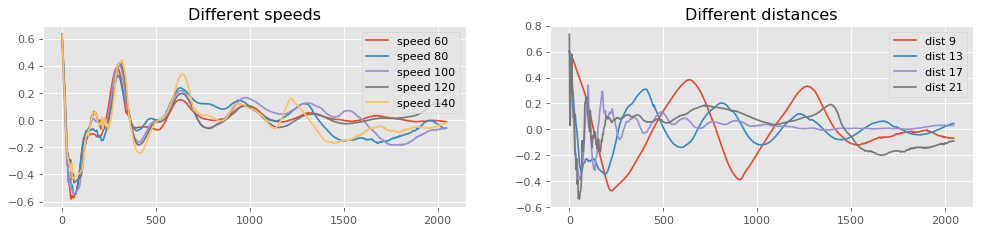

In [19]:
plt.figure(num=None, figsize=(15, 3), dpi=80)
plt.subplot(1, 2, 1)
for speed in range(60, 150, 20): 
    data = contact_signals[10][ (contact_signals['distance'] == PLT_DISTANCE) 
                               & (contact_signals['speed'] == speed) ].tolist()[0]
    plt.plot(data, label='speed %d' % speed)
    plt.title('Different speeds')
plt.legend()
plt.subplot(1, 2, 2)  
for distance in range(9, 22, 4):
    data = contact_signals[10][ (contact_signals['distance'] == distance) 
                               & (contact_signals['speed'] == PLT_SPEED) ].tolist()[0]
    plt.plot(data, label='dist %d' % distance)
    plt.title('Different distances')
plt.legend()

/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:737: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:738: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:739: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:740: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


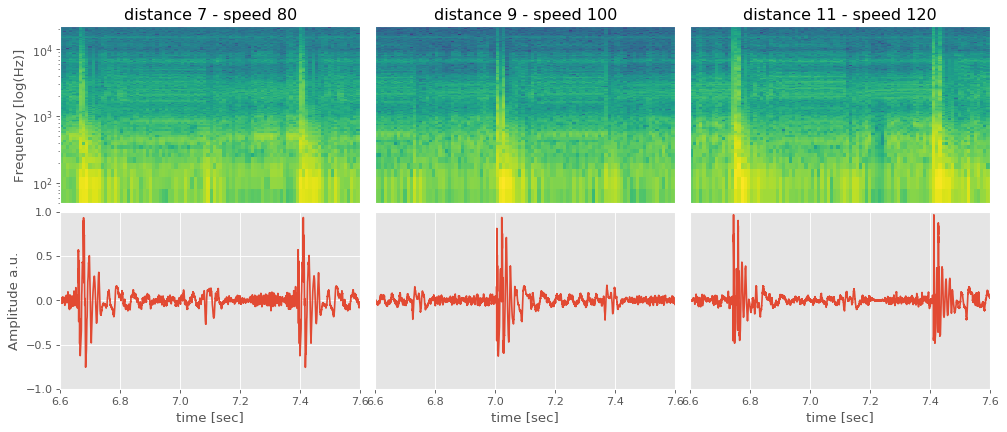

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure(num=None, figsize=(15, 6), dpi=80)
outer = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.2)

SEGMENT_LEN = 535
FRAMERATE = 44100.

def generate_spectrogram(data):
    '''
    Generates a spectrogram with logarithmically scaled frequency dimension.
    '''
    f, t, Sxx = signal.spectrogram(data, fs=FRAMERATE, scaling='density', mode='psd', nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx

for i in range(3):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.05)
    ax = plt.Subplot(fig, inner[0])
    ax.set_title("distance %d - speed %d" % (i * 2 + 7, i * 20 + 80))
    if i == 0:
        ax.set_ylabel("Frequency [log(Hz)]")
    else:
        ax.get_yaxis().set_visible(False)
    dat = get_record(i * 2 + 7, i * 20 + 80)
    f, t, Sxx = generate_spectrogram(dat)
    timeline = np.linspace(0, len(dat) / 44100., len(dat))
    ax.pcolormesh(t, f, Sxx, label='spectrogram')
    ax.set_yscale('log')
    ax.set_ylim((50, 22050))
    ax.get_xaxis().set_visible(False)
    # show two seconds of the signals spectrogram
    ax.set_xlim((6.6, 7.6))
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.set_xlim((6.6, 7.6))
    ax.set_ylim((-1., 1.))
    ax.set_xlabel("time [sec]")
    if i == 0:
        ax.set_ylabel("Amplitude a.u.")
    else:
        ax.get_yaxis().set_ticks([])
    # plot raw signal
    ax.plot(timeline, dat)
    fig.add_subplot(ax)

In [21]:
from sklearn.manifold import TSNE

# scale data
contacts = contact_signals.iloc[:, 2:].values
contacts = np.reshape(contacts, [-1, ])
#contacts = [ np.array(c) for c in contacts ]
print(np.shape(contacts))
print(np.shape(contacts[0]))
print(np.shape(contacts[0][0]))
#X_train, X_test, y_train, y_test = train_test_split(x_std, y, test_size=test_percentage, random_state=42)

tsne = TSNE(n_components=2, random_state=0)
#x_test_2d = tsne.fit_transform(contacts)
np.shape(contact_signals[contact_signals.distance == 11].iloc[:, 2:].values[0][0])

(6300,)
(2048,)
()


(2048,)

In [22]:
FRAMERATE = 44100.
SEGMENT_LEN = 535

def generate_spectrum(data):
    return signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)


Text(0,0.5,'Frequency power')

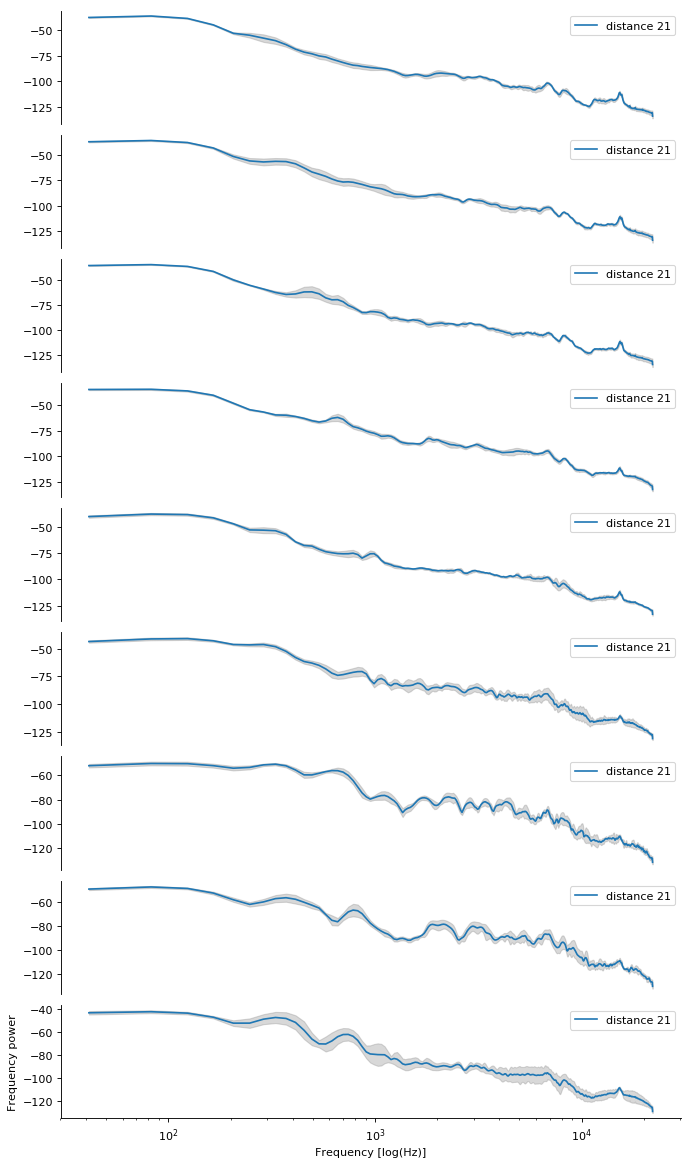

In [29]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1

plt.style.use('default')

for dist in df.distance.sort_values().unique():
    dat = contact_signals[contact_signals.distance == dist].iloc[:, 2:].dropna()
    averages = []
    for i in range(len(dat)):
        cs = dat.iloc[i].tolist()
        f, Pxx = generate_spectrum(cs)
        Pxx = 10 * np.log10(Pxx)
        avg = np.mean(Pxx, axis=0)
        power = avg.sum()
        averages.append(avg)
    average = np.mean(averages, axis=0)
    std_dev = np.std(averages, axis=0)
    #std_dev[np.abs(std_dev) < 1e-5] = 1e-5
    #print(std_dev[:-10])
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    # plt.errorbar(f, average, yerr=std_dev, label='distance %d' % dist)
    
    
    plt.plot(f, average, label='distance %d' % distance)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

Text(0,0.5,'Frequency power')

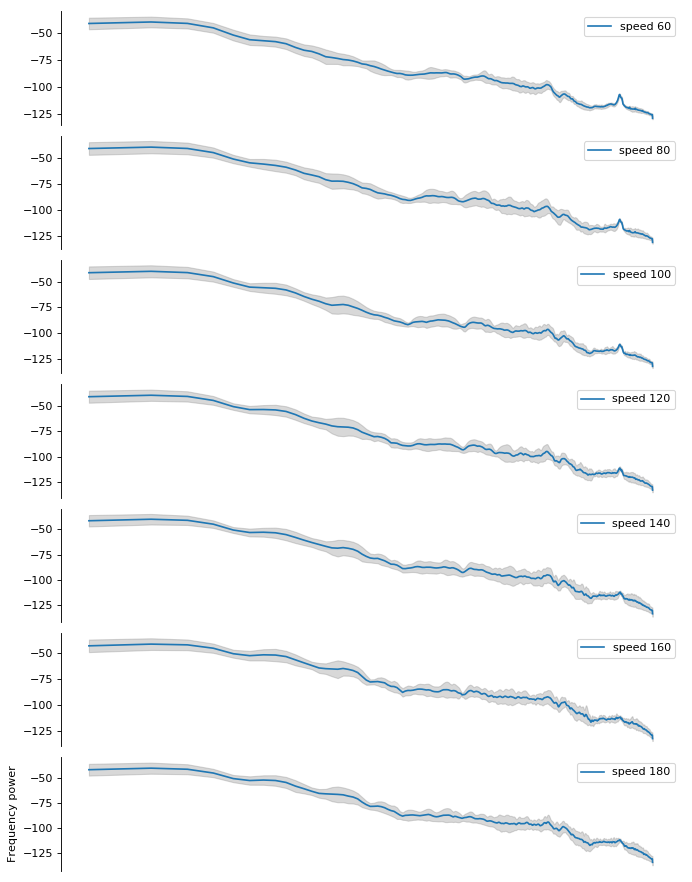

In [27]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1

for speed in df.speed.sort_values().unique():
    dat = contact_signals[contact_signals.speed == speed].iloc[:, 2:].dropna()
    averages = []
    for i in range(len(dat)):
        cs = dat.iloc[i].tolist()
        f, Pxx = generate_spectrum(cs)
        Pxx = 10 * np.log10(Pxx)
        avg = np.mean(Pxx, axis=0)
        power = avg.sum()
        averages.append(avg)
    average = np.mean(averages, axis=0)
    std_dev = np.std(averages, axis=0)
    #std_dev[np.abs(std_dev) < 1e-5] = 1e-5
    #print(std_dev[:-10])
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    
    #plt.errorbar(f, average, yerr=std_dev, label='speed %d' % speed)
    
    plt.plot(f, average, label='speed %d' % speed)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

Data prepared:
 -- samples	6237
 -- features	512
 -- test size	4178
 -- train size	2059


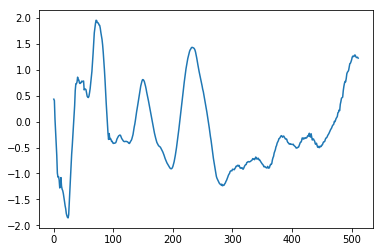

In [290]:
contact_events = []
distance_values = np.array([])
reduce_res_by = 4

for i in range(len(contact_signals)):
    cs = contact_signals.iloc[i, 2:101].tolist()
    contact_events.append(cs)
    ys = [contact_signals.distance[i]] * len(cs)
    distance_values = np.append(distance_values, ys)

contact_events = np.reshape(contact_events, [-1, 2048])
contact_events = [ x[::reduce_res_by] for x in contact_events ]

contact_events = StandardScaler().fit_transform(contact_events)

X_train, X_test, y_train, y_test = train_test_split(contact_events, 
                                                    distance_values, 
                                                    test_size=.33, 
                                                    random_state=42)
print('Data prepared:\n -- samples\t%d\n -- features\t%d\n -- test size\t%d\n -- train size\t%d' 
      % (len(contact_events), len(contact_events[0]), len(X_train), len(X_test)))
plt.plot(X_train[1])

In [332]:
weights = { 'W1' : tf.Variable(tf.random_normal([3, 1, 32])),
            'W2' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W3' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W4' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W5' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W6' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W7' : tf.Variable(tf.random_normal([3, 32, 32])) }

def conv(in_features, kernel, stride=1):
    convolution = tf.nn.conv1d(in_features, kernel, stride=stride, padding='SAME')
    return tf.layers.max_pooling1d(convolution, 3, 2)
    

# build net
x = tf.placeholder(dtype=tf.float32, shape=[None, 512, 1])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
#relative_y = tf.divide(y, 23.)
# window the input
#hann = tf.contrib.signal.hann_window(512, periodic=False, dtype=tf.float32, name=None)
#hann = tf.reshape(hann, shape=[-1, 512, 1])
#x_windowed = tf.multiply(x, hann)

conv1 = conv(x, weights['W1'], stride=2)
conv2 = conv(conv1, weights['W2'], stride=2)
#conv3 = conv(conv2, weights['W3'], stride=2)
#conv4 = conv(conv3, weights['W4'], stride=2)
#conv5 = conv(conv4, weights['W5'], stride=2)
#conv6 = conv(conv5, weights['W6'], stride=2)
#conv7 = conv(conv6, weights['W7'], stride=2)
print(conv2)
flaty = tf.layers.flatten(conv2)
print(flaty)
# output a percentage of antenna length


fc1   = fully_connected(flaty, 512, activation=tf.nn.relu)
fc2   = fully_connected(fc1, 512, activation=tf.nn.relu)
#fc1   = fully_connected(flaty, 128, activation=tf.nn.relu)
fc3   = fully_connected(fc2, 128, activation=tf.nn.relu)
#fc2   = fully_connected(fc1, 128, activation=tf.nn.relu)
sample   = fully_connected(fc3, 1, activation=tf.nn.relu)
#sample = out #tf.multiply(out, 23.)

loss = tf.losses.mean_squared_error(y, sample)
train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Tensor("max_pooling1d_15/Squeeze:0", shape=(?, 31, 32), dtype=float32)
Tensor("flatten_77/Reshape:0", shape=(?, 992), dtype=float32)


Iteration 9 finished with mean error 0.33000
Iteration 19 finished with mean error 0.17924
Iteration 29 finished with mean error 0.16533
Iteration 39 finished with mean error 0.13038
Iteration 49 finished with mean error 0.10096
Accuracy	0.7959025898724391
Difference	0.29903005712237724
R2 Score	0.9909702994755796
Contact at 11.0 cm < - > 11.5939 cm prediction
Contact at 15.0 cm < - > 16.0050 cm prediction
Contact at 13.0 cm < - > 13.0855 cm prediction
Contact at 11.0 cm < - > 11.2011 cm prediction
Contact at 5.0 cm < - > 4.7006 cm prediction
Contact at 7.0 cm < - > 6.9945 cm prediction
Contact at 15.0 cm < - > 15.1545 cm prediction
Contact at 21.0 cm < - > 21.0030 cm prediction
Contact at 5.0 cm < - > 5.0773 cm prediction
Contact at 9.0 cm < - > 9.1916 cm prediction
Mean Divergence	0.32933210712894184


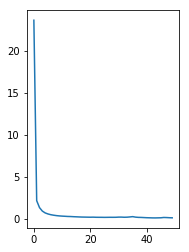

In [333]:
tf.set_random_seed(42)

EPOCHS = range(50)
BATCH_SIZE = 15
loss_summary = []

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in EPOCHS:
        epoch_mse = []
        for index, offset in enumerate(range(0, len(X_train), BATCH_SIZE)):
            xs = X_train[offset:offset+BATCH_SIZE]
            xs = np.reshape(xs, [len(xs), len(xs[0]), 1])
            ys = y_train[offset:offset+BATCH_SIZE]
            ys = np.reshape(ys, [len(ys), 1])
            _, mse = sess.run([train, loss], feed_dict={ x : xs, y : ys })
            epoch_mse.append(mse)
        if (i+1) % 10 == 0:
            print('Iteration {} finished with mean error {:.5f}'.format(i, np.mean(epoch_mse)))
        loss_summary.append(np.mean(epoch_mse))
    
    predictions = []

    X_test = np.reshape(X_test, [-1, len(X_test[0]), 1])
    y_test = np.reshape(y_test, [-1, 1])
    for i in range(len(X_test)):
        p = sess.run(sample, feed_dict={ x : [X_test[i]], y : [y_test[i]] })
        predictions.append(p)

    predictions = np.ravel(predictions)
    false_predictions = np.sum([ (p - t) > 0.2 for p, t in zip(predictions, y_test)  ])

    accuracy = float(len(predictions)) / float((len(predictions) + false_predictions))

    print('Accuracy\t{}'.format(accuracy))
    
    difference = np.mean(np.power(np.subtract(predictions, np.ravel(y_test)), 2))
    print('Difference\t{}'.format(difference))
    
    r2 = r2_score(np.ravel(y_test), predictions)
    print('R2 Score\t{}'.format(r2))
        
plt.subplot(1, 2, 1)
plt.plot(loss_summary)
for i in range(10):
    print("Contact at {} cm < - > {:.4f} cm prediction".format(np.ravel(y_test)[i], predictions[i]))
print("Mean Divergence\t{}".format(np.mean(np.abs(np.ravel(y_test) - predictions))))